In [3]:
from Solvers import adv_solver, span_solver, span_solver2, span_dual_relax
from Adversary import Adversary, Problem, to_str, visualize
import numpy as np
import matplotlib.pyplot as plt
import itertools
from Examples import exact_k, threshold_k
from ElementDistinctness import ED
from copy import deepcopy as copy
import scipy
import cvxpy as cp
import itertools
import matplotlib as mpl
mpl.rcParams['figure.dpi'] =200
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
# import graphviz
# import pygraphviz as pgv # pygraphviz should be available

In [5]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1)))

def sublist(L, indices):
    sublist = []
    for i in indices:
        sublist.append(L[i])
    return tuple(sublist)
    
def get_flow2_pairs(subset):
    return [(subset[:j] + subset[j+1:], subset[j]) for j in range(len(subset))]

def get_1_certs(problem):
    yes_set = set()
    no_set = set()
    index_sets = powerset(range(problem.n))
    for yes_instance in problem.yes_instances:
        for indices in index_sets:
            yes_set.add(sublist(yes_instance, indices))
    
    for no_instance in problem.no_instances:
        for indices in index_sets:
            no_set.add(sublist(no_instance, indices))
            
    print('yes', yes_set)
    print('no',no_set)
    return yes_set - no_set
    
def learning_graph_solver(problem):
    n = problem.n
    K = cp.Variable(nonneg=True)
    index_sets = powerset(range(n))
    weight_mapping = set()
    for yes in problem.yes_instances + problem.no_instances:
        for indices in index_sets:
            weight_mapping.add(sublist(yes, indices))
    weight_mapping = {mapping: i for (mapping, i) in zip(weight_mapping, list(range(len(weight_mapping))))}
    edges = set()
    for S in index_sets:
        for j in range(n):
            if j not in S:
                edges.add((S, j))
                
    edges = list(edges)
    r = {edge: cp.Variable(problem.yes_len) for edge in edges}
    p = {edge: cp.Variable(problem.yes_len, nonneg=True) for edge in edges}
    w = {edge: cp.Variable(len(weight_mapping), nonneg=True) for edge in edges}
    constraints = []
    for edge in edges:
        for yes_index in range(problem.yes_len):
            yes = problem.yes_instances[yes_index]
            constraints.append(
                cp.bmat([
                    [r[edge][yes_index], p[edge][yes_index]],
                     [p[edge][yes_index], w[edge][weight_mapping[sublist(yes, edge[0])]]]
                    ]) >> 0
            )
    constraints += [
        -cp.sum(cp.vstack([r[edge][yes_index] for edge in edges])) >= -1 for yes_index in range(len(problem.yes_instances)) 
    ]
    
    constraints += [
        K - cp.sum(cp.vstack([w[edge][weight_mapping[sublist(no, edge[0])]] for edge in edges])) >= 0 for no in problem.no_instances
    ]
    one_certs = get_1_certs(problem)
    for subset in index_sets:
        for yes_index in range(problem.yes_len):
            yes = problem.yes_instances
            if sublist(yes, subset) not in one_certs and len(subset) > 0: 
                flow1 = [0] + [p[(subset, j)][yes_index] for j in range(n) if j not in subset]
                flow2 = [p[(sub)][yes_index] for sub in get_flow2_pairs(subset)]
                constraints += [
                    cp.sum(cp.vstack(flow1)) - cp.sum(cp.vstack(flow2)) == 0
                ]
    
    constraints += [
        cp.sum(cp.vstack(
            [p[((), j)][yes_index] for j in range(n)
            ])) == 1 for yes_index in range(problem.yes_len)
    ] 
    
    opt_problem = cp.Problem(cp.Minimize(K), constraints)
    opt_problem.solve(verbose=True)
#     return {index: p[index].value for index in p}, {index: w[index].value for w in }              
    
def get_all_sublists(string, sub_len):
    substrings = set()
    for indices in itertools.combinations(range(len(string))):
        substring.append(tuple(string[i] for i in indices))
    return substrings

def dual_learning_graph(problem):
    n = problem.n
    pset = powerset(range(n))
    alpha = {(subset, yes): cp.Variable(nonneg=True) for subset, yes in itertools.product(pset, problem.yes_instances)}
    one_certs = get_1_certs(problem)
    k = {no: cp.Variable(nonneg=True) for no in problem.no_instances}
    substrings = set()

    
    
    

[[''], ['0', '1', '2'], ['01', '02', '12'], ['012']]


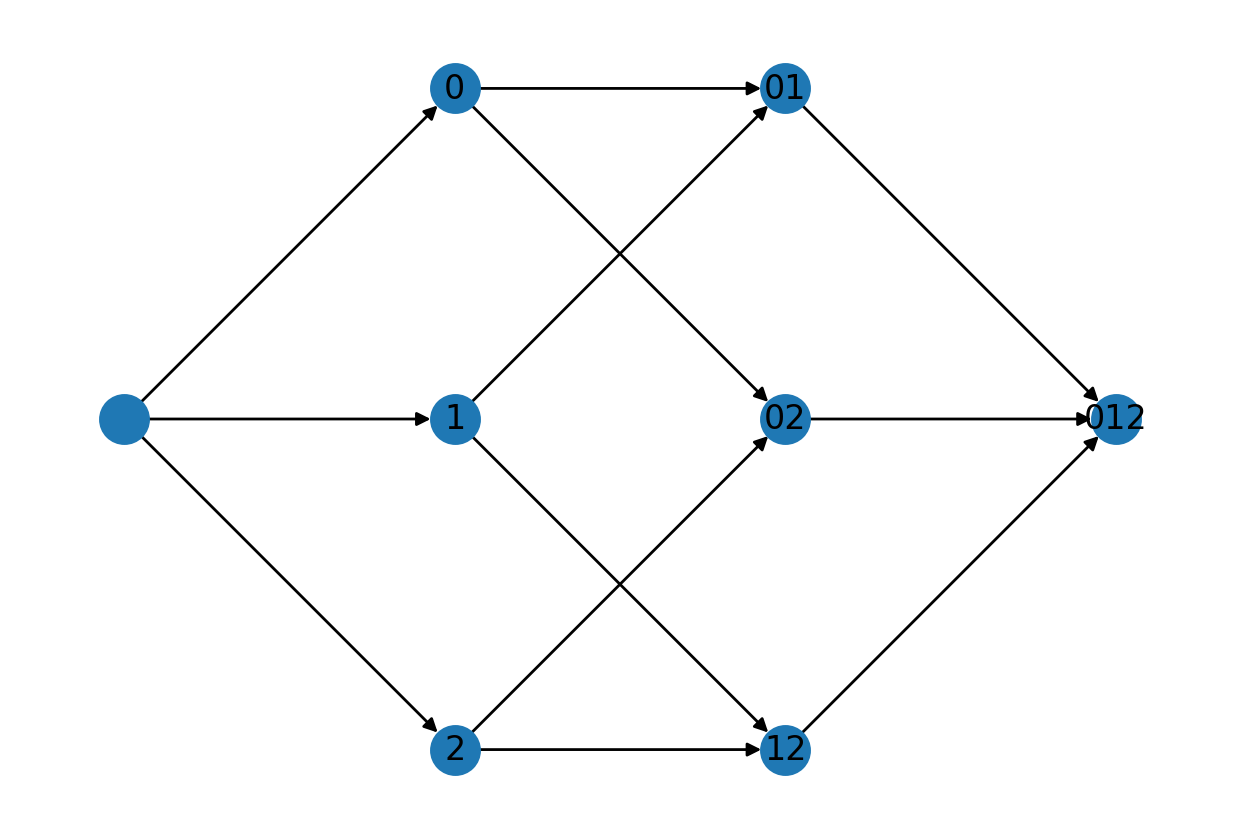

In [59]:
def multilayered_graph(layers, edges):
    # extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
    G = nx.DiGraph()
    for i, layer in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    G.add_edges_from(edges)
    return G

def learning_graph_frame(problem):
    n = problem.n
    one_certs = get_1_certs(problem)
    levels = [
            [to_str(x) for x in itertools.combinations(list(range(n)), i)]
        for i in range(n+1)
    ]
    print(levels)


    edges = []
    for i in range(len(levels)-1):
        curr_level = levels[i]
        next_level = levels[i+1]
        for curr in curr_level:
            for nextl in next_level:
                if len(set(nextl) - set(curr)) == 1:
                    edges.append((curr,nextl))
    G = multilayered_graph(levels, edges)
    pos = nx.multipartite_layout(G, subset_key="layer")
    
    nx.draw(G, pos=pos, with_labels=True)
prob = threshold_k(3, 2)
learning_graph_frame(prob)



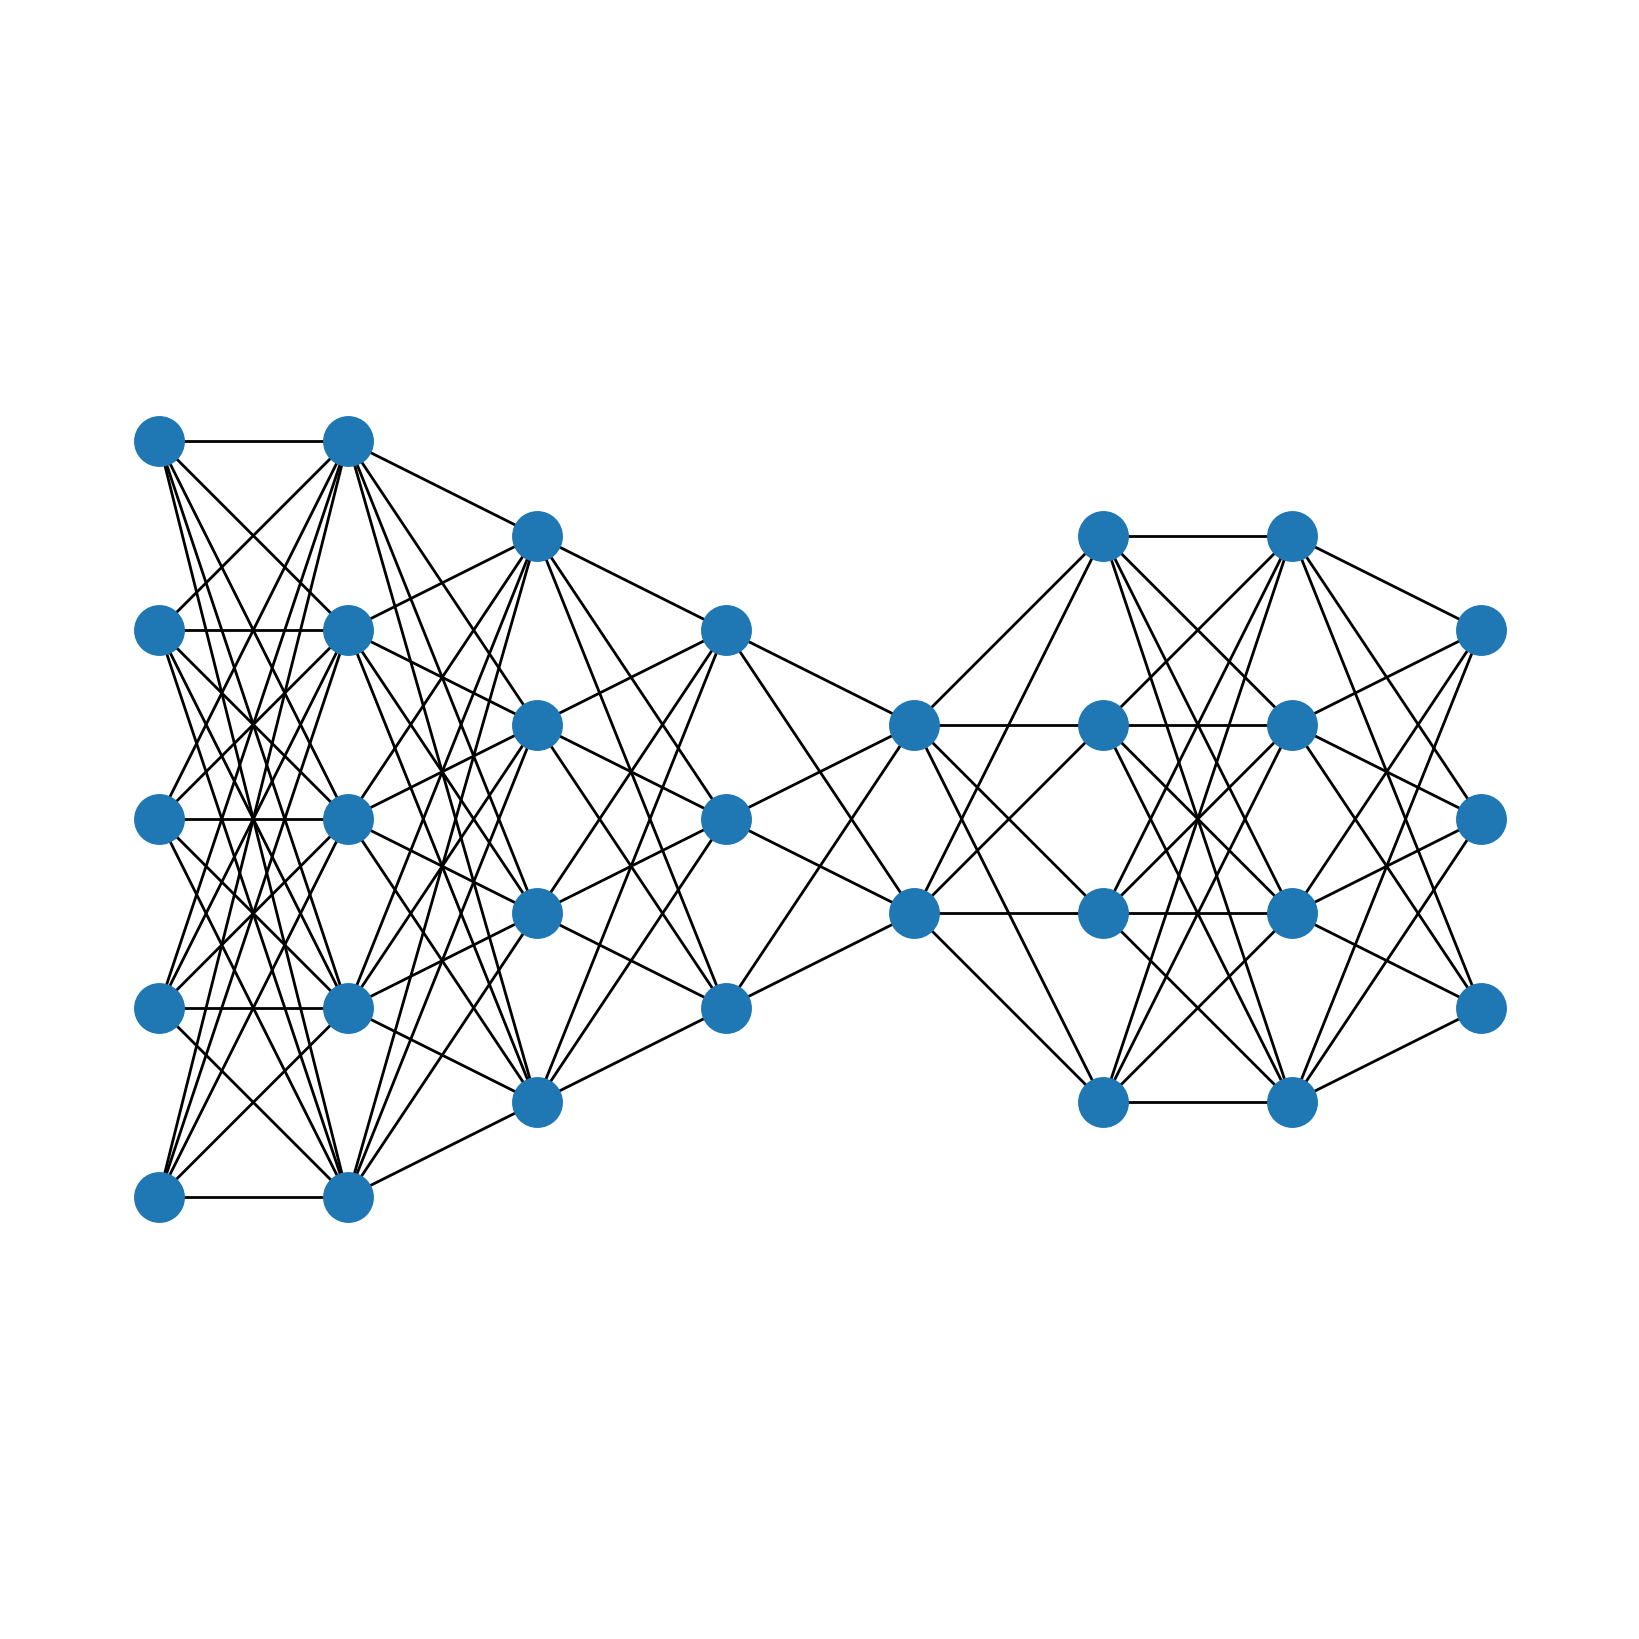

In [48]:
subset_sizes = [5, 5, 4, 3, 2, 4, 4, 3]
subset_color = [
    "gold",
    "violet",
    "violet",
    "violet",
    "violet",
    "limegreen",
    "limegreen",
    "darkorange",
]





G = multilayered_graph(*subset_sizes)
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=color, with_labels=False)
plt.axis("equal")
plt.show()

In [16]:
{1,2,3} - {2,3}

{1}

In [21]:
print(())

()
